# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance,variance_decomposition_ex_post
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [3]:
git=GitHub(token,repo_owner,repo_name,branch)
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

# Loading Benchmark

In [5]:
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()
days=(today-start_date).days
remaining=days%500
numbers_of_table=days//500
tickers=Binance.get_market_cap()['Ticker'].iloc[:40].to_list()
temp_end=start_date
scope_prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    scope_prices=scope_prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(remaining))
data=Binance.get_price(tickers,temp_end)
scope_prices=scope_prices.combine_first(data)
scope_prices=scope_prices.sort_index()
scope_prices = scope_prices[~scope_prices.index.duplicated(keep='first')]
scope_prices.index=pd.to_datetime(scope_prices.index)
tickers2=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()
prices=scope_prices[tickers2]
returns=np.log(1+prices.pct_change(fill_method=None))
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

results={}

if 'USDCUSDT' in returns_to_use.columns:
    
    cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

else:

    cash=[]
# gold_positions=np.where(returns_to_use.columns=='GOLD.PA')[0][0]
#om_limit=np.where(returns_to_use.columns=='OMUSDT')[0][0]

for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]        
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00}#,
                                                                       ])# {'type': 'eq', 'fun': lambda weights: weights[gold_positions]-0.00}])
        
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
        pass

rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T
rolling_optimization.loc[dates_end[0]]=1/len(dataframe.columns)
rolling_optimization=rolling_optimization.sort_index()

performance_model=pd.DataFrame()

In [6]:
q=rebalanced_dynamic_quantities(dataframe,rolling_optimization.iloc[:-2])
results=q*dataframe

performance_model['Fund']=results.sum(axis=1)
performance_model['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_model_pct=performance_model.copy()
performance_model_pct=performance_model_pct.pct_change(fill_method=None)

# Importing Data

In [8]:
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [9]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [11]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
quantities_api=Binance.binance_api.user_asset()

current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [14]:
# trade_history=pd.read_excel('Trades USDT.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))

In [15]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

TRXUSDT 0
BTCUSDT 1
TRXUSDT 2
BNBUSDT 3
ETHUSDT 4
SOLUSDT 5
BNBUSDT 6
USDTTRY 7
JASMYUSDT 8
BNBUSDT 9
BBUSDT 10
USDTTRY 11
BNBUSDT 12
USDTTRY 13
TRXUSDT 14
USDTTRY 15
JASMYUSDT 16
BNBUSDT 17
BBUSDT 18
OMUSDT 19
OMUSDT 20
OMUSDT 21
TRXUSDT 22
BTCUSDT 23
OMUSDT 24
BTCUSDT 25
TRXUSDT 26
TRXUSDT 27
BBUSDT 28
BNBUSDT 29
TRXUSDT 30
BTCUSDT 31
TRXUSDT 32
BTCUSDT 33
MKRUSDT 34
BTCUSDT 35
MKRUSDT 36
EURUSDT 37
EURUSDT 38
BBUSDT 39
BNBUSDT 40
JASMYUSDT 41
PEPEUSDT 42
NOTUSDT 43
NOTUSDT 44
NOTUSDT 45
BBUSDT 46
BBUSDT 47
PEPEUSDT 48
JASMYUSDT 49
BTCUSDT 50
BTCUSDT 51
TRXUSDT 52
BTCUSDT 53
BNBUSDT 54
BTCUSDT 55
BNBUSDT 56
BTCUSDT 57
BNBUSDT 58
BTCUSDT 59
BNBUSDT 60
BTCUSDT 61
BNBUSDT 62
BNBUSDT 63
BTCUSDT 64
BNBUSDT 65
JASMYUSDT 66
JASMYUSDT 67
ENSUSDT 68
ARUSDT 69
BTCUSDT 70
UMAUSDT 71
BTCUSDT 72
UMAUSDT 73
ETHUSDT 74
XRPUSDT 75
BTCUSDT 76
XRPUSDT 77
BTCUSDT 78
NEARUSDT 79
BTCUSDT 80
LPTUSDT 81
BTCUSDT 82
NEARUSDT 83
EURUSDT 84
BTCUSDT 85
INJUSDT 86
BTCUSDT 87
FETUSDT 88
EURUSDT 89
EURUSDT 90
EURU

In [16]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

historical_positions.rename(columns={'TRYUSDT': 'USDTTRY'}, inplace=True)

In [17]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_373012\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [18]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()


In [19]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:80].to_list()

In [20]:
holding=Binance.get_inventory()
last_prices=Binance.get_price(list(q.iloc[-1].keys()))

positions=pd.DataFrame(q.iloc[-1]*last_prices).T
positions['Weights Model']=positions[positions.columns]/positions[positions.columns].sum()

condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
holding_tickers.remove("USDCUSDT")
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,last_book_cost,holding.loc[condition],positions['Weights Model'],realized_pnl],axis=1)
pnl.columns=['Average Cost','Book Cost','Price in USDT','Weights','Weights Model','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Average Cost']=np.nan

pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100
pnl.sort_values(by='Weights',ascending=False).round(4)

,Average Cost,Book Cost,Price in USDT,Weights,Weights Model,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,NaN,2085.7319,2127.0035,0.9999,1.0000,-121.1884,162.46,41.2716,1.9788
TRXUSDT,0.2647,872.3899,1110.6133,0.5221,0.5633,-12.2962,238.22,225.9238,10.8319
BTCUSDT,68795.5284,565.5529,938.2991,0.4411,0.4367,13.0697,372.75,385.8197,18.4980
OMUSDT,1.1299,526.3213,77.7429,0.0366,0.0000,0.0000,-448.58,-448.5800,-21.5071
ETHUSDT,3654.5327,0.1328,0.1534,0.0001,0.0000,55.9949,0.02,56.0149,2.6856
ARUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,51.0185,0.00,51.0185,2.4461
XRPUSDT,0.5511,0.0000,0.0000,0.0000,0.0000,-6.1147,0.00,-6.1147,-0.2932
BCHUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000
XLMUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000
LINKUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000


In [21]:
selling_amount=pd.DataFrame()

selling_amount['Portfolio']=pnl['Weights']
selling_amount['Model']=pnl['Weights Model']
selling_amount['Positions']=pnl['Price in USDT']

selling_amount['Model Positions']=selling_amount['Model']*selling_amount.loc['Total','Positions']
selling_amount['Spread']=selling_amount['Model Positions']-selling_amount['Positions']
selling_amount.sort_values(by='Model',ascending=False).round(2)

,Portfolio,Model,Positions,Model Positions,Spread
Total,1.00,1.00,2127.00,2127.00,0.00
TRXUSDT,0.52,0.56,1110.61,1198.15,87.54
BTCUSDT,0.44,0.44,938.30,928.85,-9.45
PEPEUSDT,0.00,0.00,0.00,0.00,-0.00
BCHUSDT,0.00,0.00,0.00,0.00,0.00
XLMUSDT,0.00,0.00,0.00,0.00,0.00
LINKUSDT,0.00,0.00,0.00,0.00,0.00
ADAUSDT,0.00,0.00,0.00,0.00,0.00
DOGEUSDT,0.00,0.00,0.00,0.00,0.00
USDCUSDT,0.00,0.00,0.03,0.00,-0.03


In [22]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [23]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [24]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [25]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')
inventory_weights.pop('USDCUSDT')


if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [26]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [27]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [29]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: d6b090c410c99292375872f598663184002af028)
✅ File pushed/updated successfully!


In [30]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [31]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [32]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [33]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: bdfb699657ca6c4b5a445afc6f0afe1fb2c95679)
✅ File pushed/updated successfully!


In [34]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [35]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [36]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()
cols=quantities.columns[quantities.columns!='USDCUSDT']

for col in cols:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index] 

In [37]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [38]:
# pnl_history['Total']

In [39]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [40]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [41]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [42]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in cols:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [43]:
pnl_history['Total']

2024-09-23   -247.226270
2024-09-24   -303.288508
2024-09-25   -320.535015
2024-09-26   -234.835798
2024-09-27   -218.316677
                 ...    
2025-09-24    -43.048749
2025-09-25   -104.969149
2025-09-26    -75.409238
2025-09-27    -74.553791
2025-09-28    144.041102
Name: Total, Length: 371, dtype: float64

<Axes: >

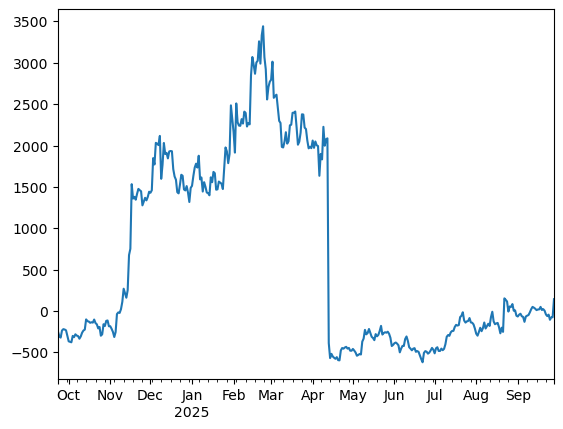

In [44]:
pnl_history['Total'].plot()

In [45]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl[-31:]

2025-08-29    -80.680751
2025-08-30      4.631266
2025-08-31    -64.917376
2025-09-01     -9.128634
2025-09-02     21.807289
2025-09-03     11.513615
2025-09-04    -30.406007
2025-09-05     -7.870188
2025-09-06    -59.574293
2025-09-07     64.103747
2025-09-08     10.429624
2025-09-09      7.514311
2025-09-10     32.069894
2025-09-11     38.330067
2025-09-12     28.157845
2025-09-13     -9.210608
2025-09-14    -12.518451
2025-09-15    -17.024334
2025-09-16      7.182172
2025-09-17      1.849051
2025-09-18     29.806058
2025-09-19    -37.805603
2025-09-20     10.375811
2025-09-21    -18.452314
2025-09-22    -45.323121
2025-09-23    -20.406501
2025-09-24     17.724228
2025-09-25    -61.920400
2025-09-26     29.559911
2025-09-27      0.855447
2025-09-28    218.594893
Name: Total, dtype: float64

In [46]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']

var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-367.7393526016783, -950.5160328166937)

In [47]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [48]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [49]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [50]:
start_date=datetime.datetime(2024,5,11)
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(weights_ex_post.columns,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(weights_ex_post.columns,temp_end)
binance_data=prices.combine_first(last_data)
binance_data=binance_data.sort_index()
binance_data = binance_data[~binance_data.index.duplicated(keep='first')]
binance_data.index=pd.to_datetime(binance_data.index)

LDUMAUSDT not retrieved
Total not retrieved
LDUMAUSDT not retrieved
Total not retrieved
LDUMAUSDT not retrieved
Total not retrieved


In [51]:
binance_data=np.log(1+binance_data.pct_change())

C:\Users\niroo\AppData\Local\Temp\ipykernel_373012\2713676895.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [52]:
weight_date=set(weights_ex_post.index)
binance_date=set(binance_data.index)

In [53]:
common_date=weight_date.intersection(binance_date)

In [54]:
binance_data2=binance_data.loc[list(common_date)].copy().sort_index()
weights_ex_post2=weights_ex_post.loc[list(common_date)].copy().sort_index()

In [55]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post2[col]*binance_data2[col]
    

In [56]:
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

In [57]:
variance_decomposition=variance_decomposition_ex_post(quantities.fillna(0).loc['2025-09':],price_pnl.loc['2025-09':])
variance_decomposition_pct=variance_decomposition.copy()
total_var=variance_decomposition['Variance'].sum()
for col in variance_decomposition_pct.columns:
    variance_decomposition_pct[col]=variance_decomposition[col]/total_var

In [58]:
variance_decomposition_pct.round(4)

,Variance,Correlation,Idiosyncratic
BNBUSDT,0.0000,0.0000,0.0000
BTCUSDT,0.2824,0.0925,0.1899
ETHUSDT,0.0001,0.0001,0.0000
OMUSDT,0.0523,0.0324,0.0198
PEPEUSDT,0.0000,0.0000,0.0000
SOLUSDT,0.0001,0.0001,0.0000
TRXUSDT,0.6652,0.0912,0.5739
USDCUSDT,-0.0000,-0.0000,0.0000
BBUSDT,0.0000,0.0000,0.0000
JASMYUSDT,0.0000,0.0000,0.0000


<Axes: >

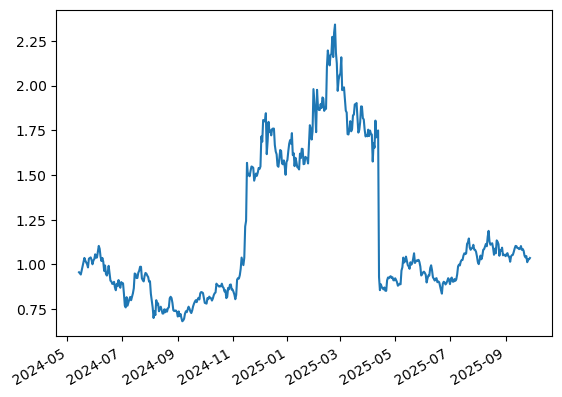

In [59]:
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

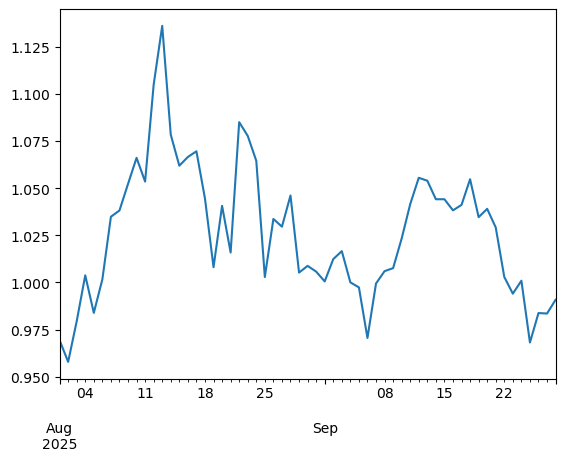

In [60]:
(1+historical_ptf['Historical Portfolio'].loc['2025-08':]).cumprod().plot()
plt.show()

## Ex ante data

In [62]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [65]:
days=120
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [66]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [69]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.7437
TRXUSDT,0.2563
ETHUSDT,0.0000
OMUSDT,0.0000
PEPEUSDT,0.0000
FLOKIUSDT,0.0000
INJUSDT,0.0000
STXUSDT,0.0000
FETUSDT,0.0000
ARBUSDT,0.0000


In [70]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.759477
TRXUSDT,0.240523


In [71]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))

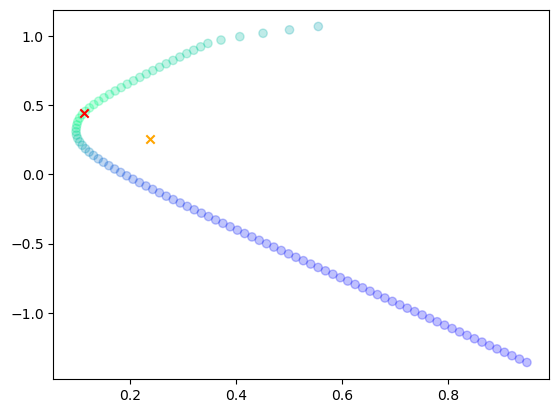

In [72]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [73]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [74]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
TRXUSDT,1110.6133,0.5221,0.0524,0.4697
BTCUSDT,938.2991,0.4411,0.0000,0.4411
OMUSDT,77.7429,0.0366,0.0000,0.0366
ETHUSDT,0.1534,0.0001,0.0000,0.0001
SOLUSDT,0.0946,0.0000,0.0000,0.0000
BNBUSDT,0.0669,0.0000,0.0939,-0.0939
USDCUSDT,0.0332,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
PAXGUSDT,0.0000,0.0000,0.7073,-0.7073


### Current results

In [76]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [77]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BNBUSDT,0.759753
TRXUSDT,0.240247


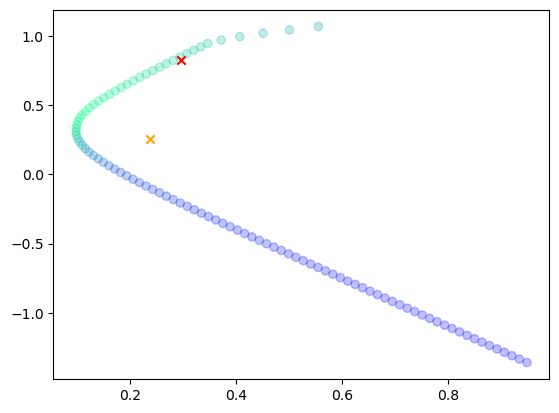

In [78]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [79]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
TRXUSDT,1110.6133,0.5221,0.2402,0.2819
BTCUSDT,938.2991,0.4411,0.0000,0.4411
OMUSDT,77.7429,0.0366,0.0000,0.0366
ETHUSDT,0.1534,0.0001,0.0000,0.0001
SOLUSDT,0.0946,0.0000,0.0000,0.0000
BNBUSDT,0.0669,0.0000,0.7598,-0.7597
USDCUSDT,0.0332,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000


# Risk Reward Analysis

In [81]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [82]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
portfolio_perf['Model']=performance_model_pct['Fund']

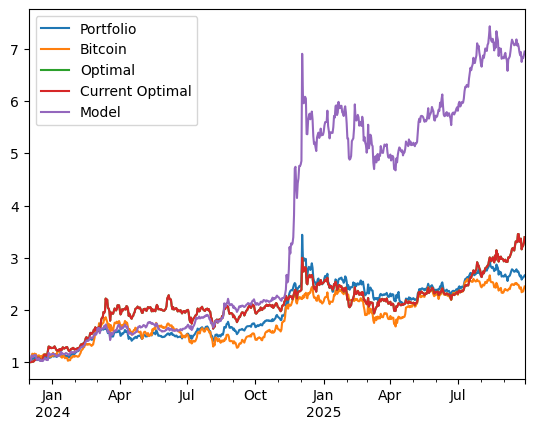

In [83]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [84]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

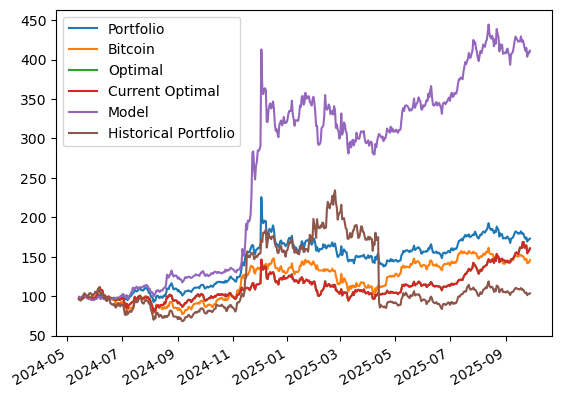

In [85]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


<Axes: >

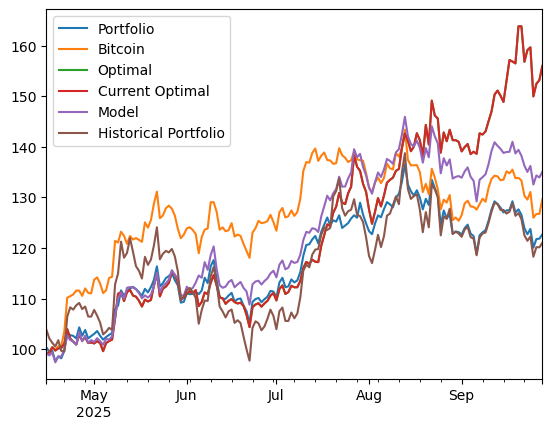

In [86]:
((1+current_perf.loc['2025-04-15':]).cumprod()*100).plot()

<Axes: >

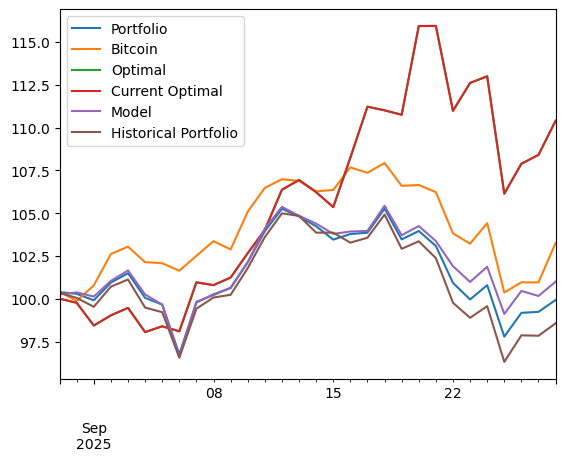

In [87]:
((1+current_perf.loc['2025-08-30':]).cumprod()*100).plot()

In [88]:
((1+current_perf.loc['2025-09':]).cumprod()*100)

,Portfolio,Bitcoin,Optimal,Current Optimal,Model,Historical Portfolio
2025-09-01,99.622165,100.911403,98.670147,98.670060,99.756866,99.483380
2025-09-02,100.654716,102.744604,99.266723,99.266768,100.671284,100.658019
2025-09-03,101.201868,103.173841,99.704147,99.704085,101.276947,101.077169
2025-09-04,99.764309,102.269505,98.285450,98.285518,99.878887,99.433826
2025-09-05,99.372995,102.204021,98.624947,98.625491,99.290841,99.169263
2025-09-06,96.483528,101.767137,98.328203,98.330504,96.253927,96.504786
2025-09-07,99.493603,102.640198,101.199106,101.200669,99.459434,99.372884
2025-09-08,99.972677,103.493588,101.034214,101.035702,99.837152,100.023178
2025-09-09,100.331518,103.013320,101.479832,101.481070,100.280858,100.182721
2025-09-10,101.839629,105.218521,102.907591,102.909015,101.762696,101.743319


## Volatilities

In [90]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.296317
 dtype: float64,
 0.2963167073502296)

In [91]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.238805
 dtype: float64,
 0.23880536144960252)

In [92]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.398037
Bitcoin            0.399385
Optimal            0.403080
Current Optimal    0.403095
Model              0.486179
dtype: float64

In [93]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.1889099917017089

In [94]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-0.43143341303215504

<Axes: >

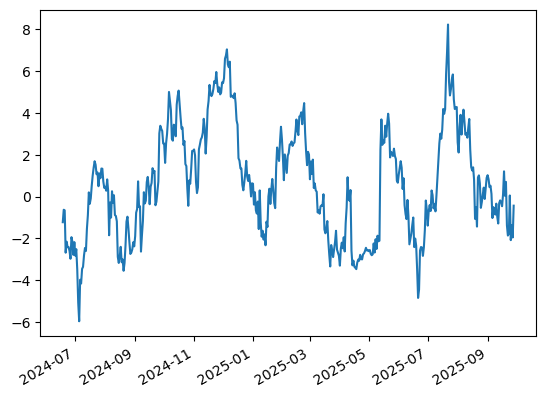

In [95]:
window=30
rolling_sharpe_ratio=current_perf['Historical Portfolio'].rolling(window).mean()*252/(current_perf['Historical Portfolio'].rolling(window).std()*np.sqrt(252))
rolling_sharpe_ratio.plot()

In [96]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.071702278513845

## Risk Contribution

In [98]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,39.601,0.8662,0.7845,0.0817
TRXUSDT,5.321,0.1338,0.0520,0.0817
Portfolio,44.922,1.0000,0.8366,0.1634


In [99]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,39.615357,0.866458,0.784826,0.081632
TRXUSDT,5.314896,0.133542,0.051910,0.081632
Portfolio,44.930252,1.000000,0.836736,0.163264


In [100]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
TRXUSDT,11.503768,0.534108,0.374544,0.159563
BTCUSDT,2.846817,0.382411,0.210605,0.171806
OMUSDT,-2.284905,0.083481,0.025268,0.058213
Portfolio,12.065680,1.000000,0.610417,0.389583


# Value At Risk

## Historical

### Optimal Weights

In [104]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.04571948672655919, -0.05354395579349693)

### Current Weights

In [106]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.0326928277664264, -0.03934049578580873)

In [107]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [108]:
var=historical_var.iloc[row]
var

TRXUSDT     -0.023996
BTCUSDT     -0.006549
OMUSDT      -0.002727
ETHUSDT     -0.000000
SOLUSDT     -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT     0.000000
Portfolio   -0.033272
Name: 2025-06-11 00:00:00, dtype: float64

In [109]:
cvar=historical_var.iloc[:row+1].mean()
cvar

TRXUSDT     -0.026572
BTCUSDT     -0.009929
OMUSDT      -0.002840
ETHUSDT      0.000000
SOLUSDT      0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.039340
dtype: float64

## Parametric

### Optimal Weights

In [112]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.04342407008702161, -0.05378355141742398)

### Current Weights

In [114]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.03499600426002113, -0.043344840563109284)

## Multivariate

### Optimal Weights

In [117]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.03905036996494553, -0.04572287019994902)

### Current Weights

In [119]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.03390848316469806, -0.038914102700877806)

In [120]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

TRXUSDT     -0.019334
BTCUSDT     -0.012092
OMUSDT      -0.002580
Portfolio   -0.034006
dtype: float64

In [121]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

TRXUSDT     -0.019316
BTCUSDT     -0.012649
OMUSDT      -0.002460
Portfolio   -0.034425
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [125]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.039618885924295216, -0.04688880319050897)

### Current Weights

In [127]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03401481413212984, -0.03908989810247529)

In [128]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [131]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03922591934773686, -0.04507425120378127)

### Current Weights

In [133]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0349460461772673, -0.04092019870083458)

In [134]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [137]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.10313870779864724, -0.12904540109240498)

### Current Weights

In [139]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06578699585860573, -0.0820728005458026)

In [140]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [143]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [144]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.04390484133234223, -0.05009102837326866)

### Current Weights

In [146]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03501782913395237, -0.040173788271771926)

In [147]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [148]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
TRXUSDT,-0.022161,-0.017844,-0.013861,-0.019334,-0.018546
BTCUSDT,-0.016721,-0.013035,-0.008933,-0.012092,-0.013558
OMUSDT,-0.001824,-0.003123,-0.002130,-0.002580,-0.003287
Portfolio,-0.040706,-0.034002,-0.024923,-0.034006,-0.035391


In [149]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
TRXUSDT,-0.021363,-0.018581,-0.013780,-0.019316,-0.018430
BTCUSDT,-0.018327,-0.012906,-0.009009,-0.012649,-0.013749
OMUSDT,-0.001518,-0.002992,-0.002380,-0.002460,-0.003618
Portfolio,-0.041207,-0.034479,-0.025169,-0.034425,-0.035797


## VaR Violation

In [151]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.027035,-0.058887,-0.054591,-0.013282
2024-01-15,-0.027035,-0.060476,-0.053125,0.038724
2024-01-16,-0.027035,-0.059674,-0.050796,-0.006809
2024-01-17,-0.027035,-0.060332,-0.052715,-0.013416
2024-01-18,-0.027035,-0.059174,-0.053218,0.008230
...,...,...,...,...
2025-09-25,-0.055487,-0.047944,-0.045887,-0.060678
2025-09-26,-0.055487,-0.047927,-0.044966,0.016464
2025-09-27,-0.055487,-0.047582,-0.045833,0.004811
2025-09-28,-0.055487,-0.047455,-0.043684,0.018376


In [152]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-15,-0.047224,-0.048156,-0.045325,-0.036380
2023-12-16,-0.047224,-0.048214,-0.044990,0.010539
2023-12-17,-0.047224,-0.048860,-0.047902,-0.013680
2023-12-18,-0.047224,-0.048966,-0.048775,0.007464
2023-12-19,-0.047224,-0.046385,-0.047258,-0.004599
...,...,...,...,...
2025-09-25,-0.028575,-0.031246,-0.034428,-0.029825
2025-09-26,-0.028575,-0.030399,-0.032590,0.014204
2025-09-27,-0.028575,-0.028833,-0.033038,0.000611
2025-09-28,-0.028575,-0.029549,-0.032227,0.006948


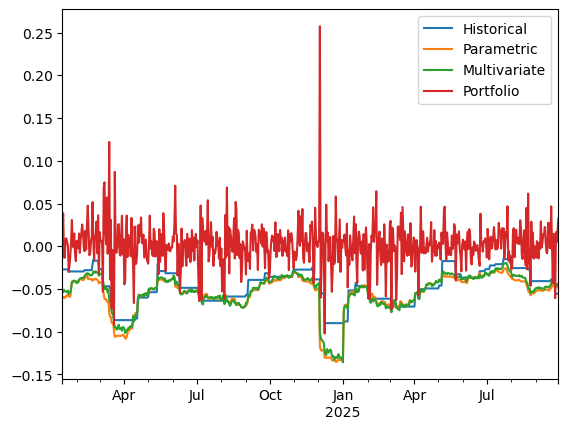

In [153]:
var_data.plot()
plt.show()

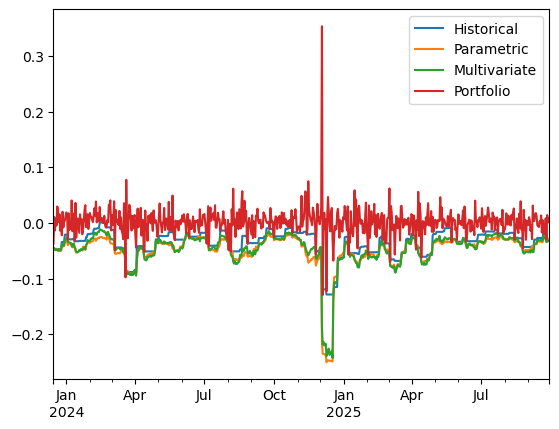

In [154]:
current_var_data.plot()
plt.show()


In [155]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.0352,0.0112,0.0112
Kupiec Stat,3.200378,28.531677,28.531677
P-value,0.073621,0.0,0.0


In [156]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.071756,0.00916,0.00916
Kupiec Stat,5.785852,34.268105,34.268105
P-value,0.016156,0.0,0.0


# Principal Component Analysis

## Historical PCA

In [159]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.86172067, 0.04290954, 0.03446851, 0.03237132, 0.02852997])

In [160]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.021393
ADAUSDT      0.019503
ALGOUSDT     0.022942
APTUSDT      0.020082
ARBUSDT      0.029383
ATOMUSDT     0.017852
AVAXUSDT     0.021167
BCHUSDT      0.010750
BNBUSDT      0.009818
BONKUSDT     0.027537
BTCUSDT      0.007516
CAKEUSDT     0.017114
CRVUSDT      0.024227
DOGEUSDT     0.023838
DOTUSDT      0.020125
ETCUSDT      0.019403
ETHUSDT      0.018474
FDUSDUSDT    0.000096
FETUSDT      0.021612
FILUSDT      0.020513
FLOKIUSDT    0.028713
GRTUSDT      0.022110
HBARUSDT     0.021966
ICPUSDT      0.020151
IMXUSDT      0.028241
INJUSDT      0.027108
LDOUSDT      0.027590
LINKUSDT     0.023202
LTCUSDT      0.015065
NEARUSDT     0.024080
NEXOUSDT     0.007719
OMUSDT       0.023575
OPUSDT       0.027545
PAXGUSDT    -0.000177
PEPEUSDT     0.025824
QNTUSDT      0.015743
RAYUSDT      0.024467
SEIUSDT      0.025672
SHIBUSDT     0.018465
SOLUSDT      0.019796
STXUSDT      0.022229
SUIUSDT      0.023839
TRXUSDT      0.005466
UNIUSDT      0.023915
USDCUSDT    -0.000014
VETUSDT   

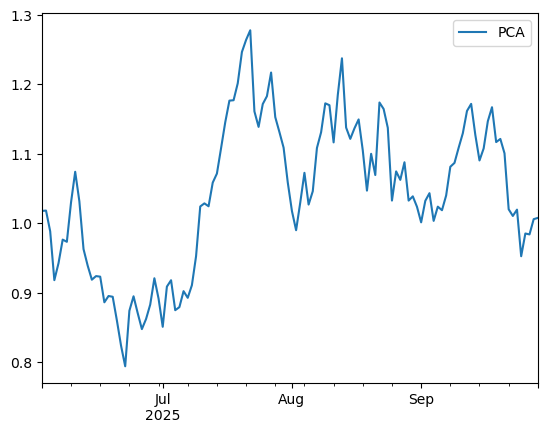

In [161]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

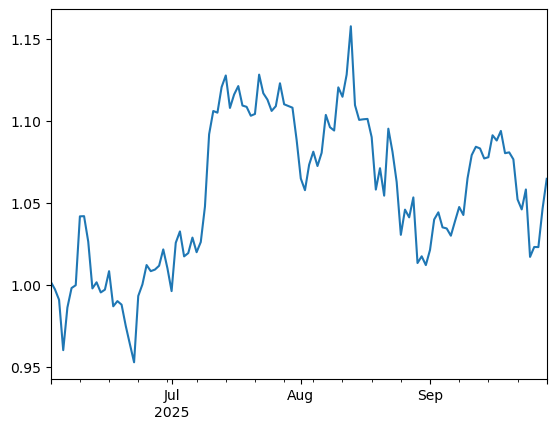

In [162]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [163]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
DOTUSDT      0.123362
SHIBUSDT     0.124443
FILUSDT      0.133524
VETUSDT      0.136052
ATOMUSDT     0.141796
GRTUSDT      0.149302
ICPUSDT      0.155104
NEARUSDT     0.163546
ADAUSDT      0.181434
PEPEUSDT     0.182587
WBETHUSDT    0.186075
ETHUSDT      0.186241
APTUSDT      0.191828
STXUSDT      0.193049
DOGEUSDT     0.195907
FETUSDT      0.197215
ETCUSDT      0.197860
SOLUSDT      0.199864
INJUSDT      0.214331
dtype: float64

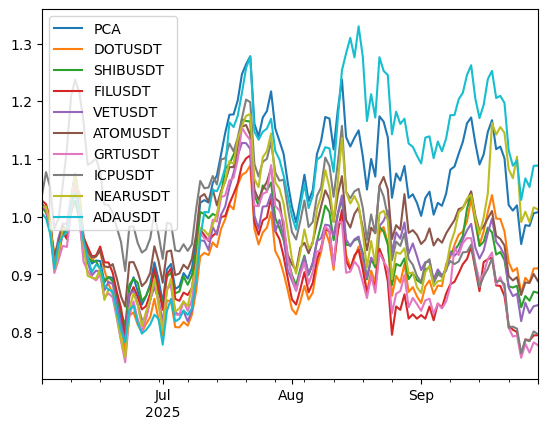

In [164]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

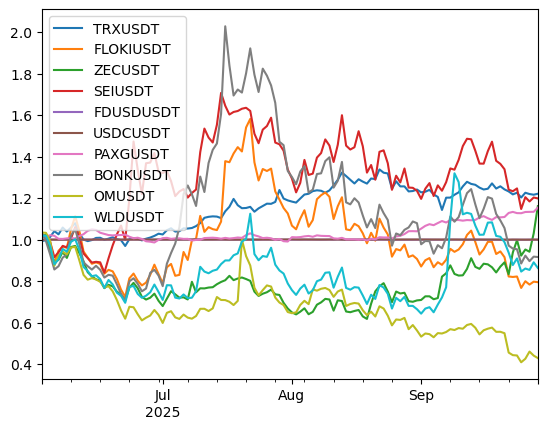

In [165]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [167]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.74887965, 0.16636191, 0.03750225, 0.02507179, 0.0221844 ])

In [168]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

TRXUSDT     0.041990
BTCUSDT     0.060731
OMUSDT      0.266440
ETHUSDT     0.158169
SOLUSDT     0.167392
BNBUSDT     0.086419
PEPEUSDT    0.220846
PAXGUSDT   -0.001987
Name: PC1, dtype: float64

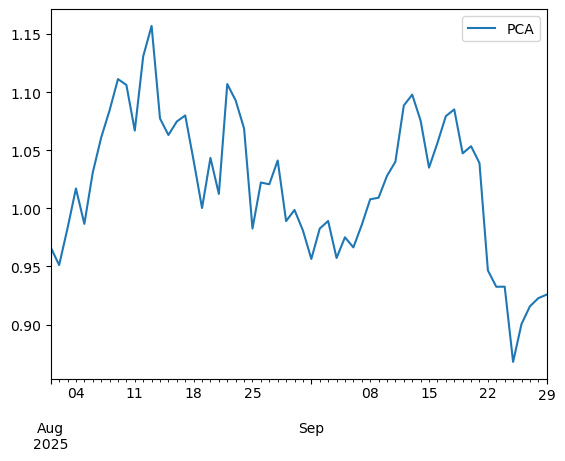

In [169]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA.iloc[-60:]).cumprod().plot()
plt.show()

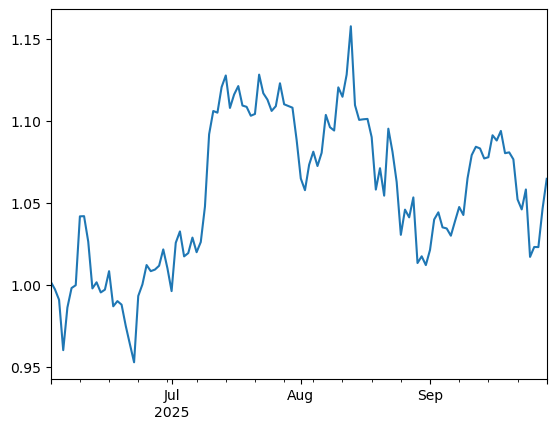

In [170]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [171]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA         0.000000
ETHUSDT     0.201704
PEPEUSDT    0.214425
SOLUSDT     0.224383
BNBUSDT     0.262629
BTCUSDT     0.286915
TRXUSDT     0.348751
OMUSDT      0.377540
PAXGUSDT    0.403144
dtype: float64

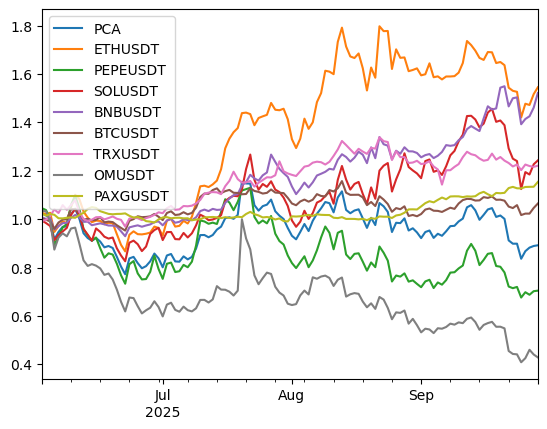

In [172]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [174]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT    1.922816
SOLUSDT     1.307222
ETHUSDT     1.113584
OMUSDT      1.019898
BTCUSDT     1.000000
BNBUSDT     0.679258
TRXUSDT     0.342575
PAXGUSDT    0.029109
Name: BTCUSDT, dtype: float64

In [175]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

SOLUSDT     2.201375
PEPEUSDT    1.854926
OMUSDT      1.784522
ETHUSDT     1.432826
BNBUSDT     1.316992
BTCUSDT     1.000000
TRXUSDT     0.596267
PAXGUSDT   -0.004653
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [177]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [178]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
PEPEUSDT,0.372676
BTCUSDT,0.296113
SOLUSDT,0.261575
OMUSDT,0.090938
BNBUSDT,0.050463
ETHUSDT,-0.018539
TRXUSDT,-0.036708
PAXGUSDT,-0.269458


### Regression to PCA

In [180]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.670782695882844

In [181]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

PCA         1.000000
ETHUSDT     0.906345
BNBUSDT     0.815528
BTCUSDT     0.756436
SOLUSDT     0.619766
PEPEUSDT    0.318075
TRXUSDT     0.268121
OMUSDT      0.139657
PAXGUSDT   -0.149871
dtype: float64

In [182]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT     1.740373
PCA         1.000000
ETHUSDT     0.963241
TRXUSDT     0.829017
BNBUSDT     0.790933
SOLUSDT     0.763823
PEPEUSDT    0.760575
OMUSDT      0.504777
PAXGUSDT   -1.041071
dtype: float64

### Correlation Matrix

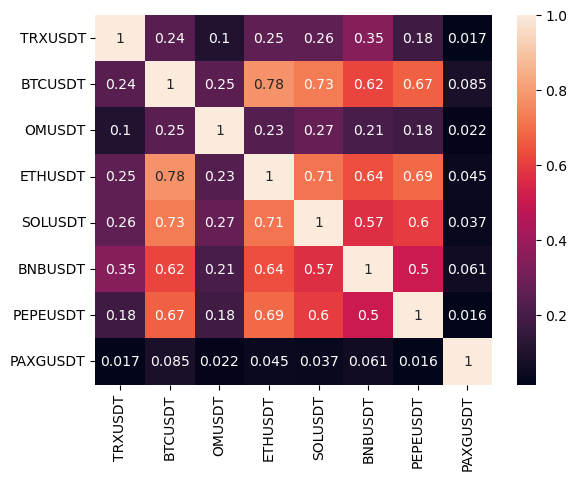

In [184]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

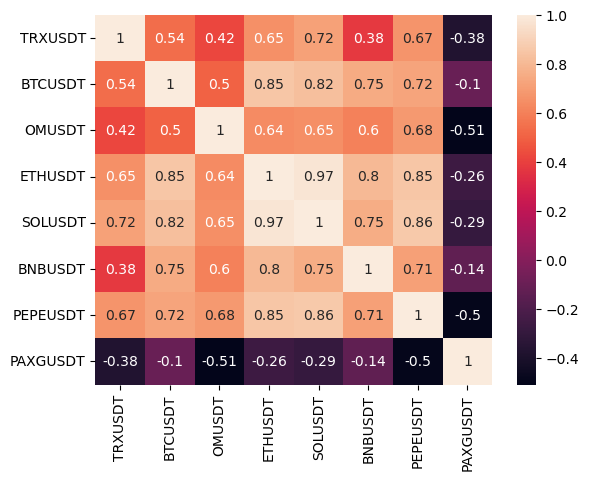

In [185]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [186]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [187]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

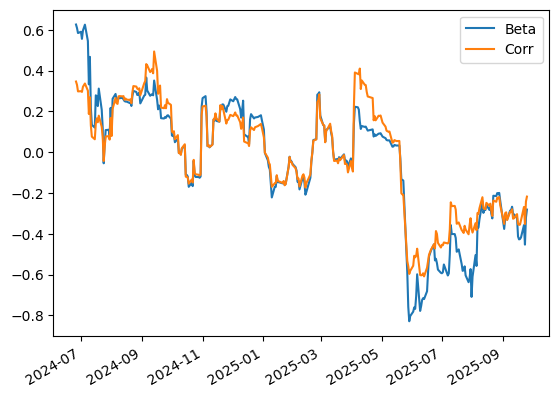

In [188]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [190]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,TRXUSDT,BTCUSDT,OMUSDT,ETHUSDT,SOLUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2023-12-14,0.000000,0.107613,0.104338,0.000000,0.000000,0.522522,0.000000,0.265527
2023-12-28,0.000000,0.000000,0.000000,0.000000,0.331762,0.668238,0.000000,0.000000
2024-01-11,0.000000,0.000000,0.560261,0.439739,0.000000,0.000000,0.000000,0.000000
2024-01-25,0.379492,0.000000,0.104622,0.000000,0.000000,0.000000,0.000000,0.515886
2024-02-08,0.066364,0.000000,0.047113,0.191144,0.041760,0.000000,0.000000,0.653620
2024-02-22,0.705974,0.000000,0.000000,0.164223,0.000000,0.129803,0.000000,0.000000
2024-03-07,0.000000,0.000000,0.000000,0.020832,0.156080,0.000000,0.046602,0.776486
2024-03-21,0.000000,0.000000,0.462471,0.000000,0.000000,0.471815,0.065714,0.000000
2024-04-04,0.000000,0.000920,0.019296,0.000000,0.000000,0.113904,0.000000,0.865879
2024-04-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [191]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [192]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0},
                                                                    {'type': 'eq', 'fun': lambda weights: weights[limit[1]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,ZECUSDT
2025-02-21,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000
2025-03-23,0.000000,0.625394,0.008027,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000
2025-04-22,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.690855,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000
2025-05-22,0.201712,0.000000,0.021626,0.0,0.0,0.0,0.000000,0.000000,0.104614,0.000000,...,0.036059,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.314287
2025-06-21,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000
2025-07-21,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.141648,0.000000,0.164899,...,0.000000,0.0886,0.0,0.0,0.0,0.0,0.000000,0.035957,0.38112,0.000000
2025-08-20,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.190815,0.000000,...,0.763477,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000
2025-09-19,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.517503,0.000000,0.001792,0.000000,...,0.000000,0.0000,0.0,0.0,0.0,0.0,0.062521,0.000000,0.00000,0.285305
2025-09-29,0.000000,0.019496,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.980504


In [193]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

AVAXUSDT    0.517503
ZECUSDT     0.285305
IMXUSDT     0.132880
WLDUSDT     0.062521
BNBUSDT     0.001792
SOLUSDT     0.000000
Name: 2025-09-19 00:00:00, dtype: float64

In [194]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
